<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
import os, datetime

from matplotlib import pyplot
pyplot.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<h2>Data Processing</h2>

In [2]:
data_path = '~/data/cd560d6ec65c4e79.csv'

#TODO: get data and read more data
# df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=1000000)
df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,5000000)], nrows=1280000)

# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['BID'].replace(to_replace=0, method='ffill', inplace=True)
df['ASK'].replace(to_replace=0, method='ffill', inplace=True)
df['BIDSIZ'].replace(to_replace=0, method='ffill', inplace=True)
df['ASKSIZ'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values(by=['DATE', 'TIME_M'], inplace=True)

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
#TODO: remove rolling mean
df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']] = df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']].rolling(2000).mean() 

In [3]:
df.head()

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
0,20200102,11:56:26.491975947,NaN,NaN,NaN,NaN,SPY
1,20200102,11:56:26.492184533,NaN,NaN,NaN,NaN,SPY
2,20200102,11:56:26.492251757,NaN,NaN,NaN,NaN,SPY
3,20200102,11:56:26.492310811,NaN,NaN,NaN,NaN,SPY
4,20200102,11:56:26.492356756,NaN,NaN,NaN,NaN,SPY


In [4]:
df.tail()

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
319995,20200102,12:18:26.607444653,323.193225,7.6770,323.21549,8.5900,SPY
319996,20200102,12:18:26.607448667,323.193235,7.6750,323.21551,8.5945,SPY
319997,20200102,12:18:26.607450569,323.193245,7.6760,323.21552,8.5935,SPY
319998,20200102,12:18:26.607453482,323.193255,7.6760,323.21553,8.5945,SPY
319999,20200102,12:18:26.607457352,323.193265,7.6775,323.21554,8.5945,SPY


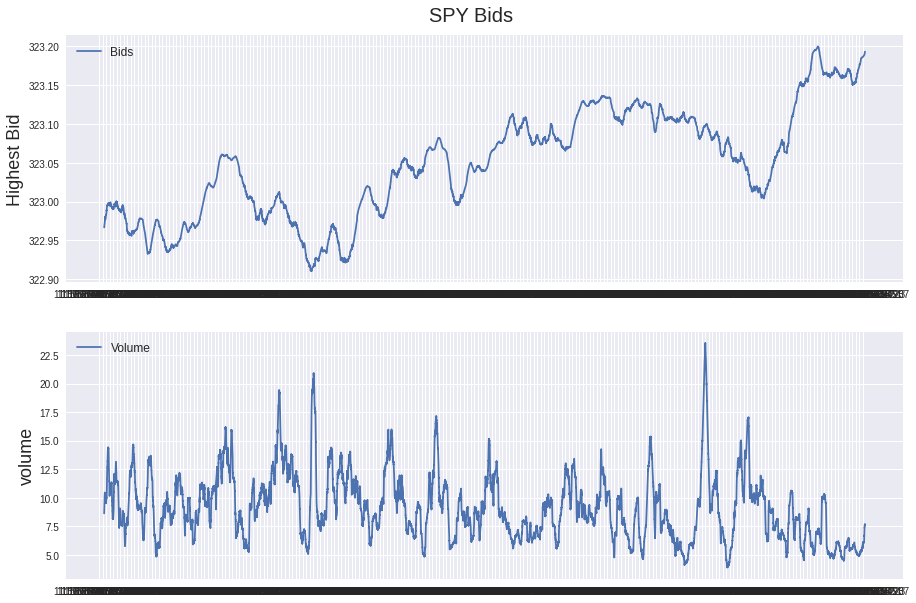

In [5]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['BID'], label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['TIME_M'].loc[::1464])
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['BIDSIZ'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['TIME_M'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [6]:
'''Calculate percentage change'''

# df['BID'] = df['BID'].pct_change()
# df['BIDSIZ'] = df['BIDSIZ'].pct_change()
# df['ASK'] = df['ASK'].pct_change()
# df['ASKSIZ'] = df['ASKSIZ'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


# '''SCALE'''
# multiplier = 1024
# df['BID'] *= multiplier
# df['ASK'] *= multiplier
# df['BIDSIZ'] *= multiplier
# df['ASKSIZ'] *= multiplier

# '''Normalize price columns'''

# min_return = min(df[['BID', 'ASK']].min(axis=0))
# max_return = max(df[['BID', 'ASK']].max(axis=0))

# print(min_return)
# print(max_return)

# # Min-max normalize price columns (0-1 range)
# df['BID'] = (df['BID'] - min_return) / (max_return - min_return)
# df['ASK'] = (df['ASK'] - min_return) / (max_return - min_return)


# '''Normalize volume column'''

# min_volume = min(df[['BIDSIZ', 'ASKSIZ']].min(axis=0))
# max_volume = max(df[['BIDSIZ', 'ASKSIZ']].max(axis=0))

# # Min-max normalize volume columns (0-1 range)
# df['BIDSIZ'] = (df['BIDSIZ'] - min_volume) / (max_volume - min_volume)
# df['ASKSIZ'] = (df['ASKSIZ'] - min_volume) / (max_volume - min_volume)

# print((max_volume - min_volume))

# Remove date, time, symbol column
df.drop(columns=['DATE'], inplace=True)
df.drop(columns=['TIME_M'], inplace=True)
df.drop(columns=['SYM_ROOT'], inplace=True)
# df.drop(columns=['BID'], inplace=True)
# df.drop(columns=['ASKSIZ'], inplace=True)
# df.drop(columns=['ASK'], inplace=True)

df = np.array(df)

In [7]:
# ttime = np.arange(0, len(df), 1)
# amp = np.sin(ttime/10) + 10 * np.sin(ttime*0.005) +np.sin(ttime*0.012) *np.random.normal(-0.2, 0.2, len(ttime))
# amp = amp.reshape(-1, 1)
#df += amp

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1)) 
#amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)

for i in range(df.shape[1]):
    df[:,i] = scaler.fit_transform(df[:,i].reshape(-1, 1)).reshape(-1) 

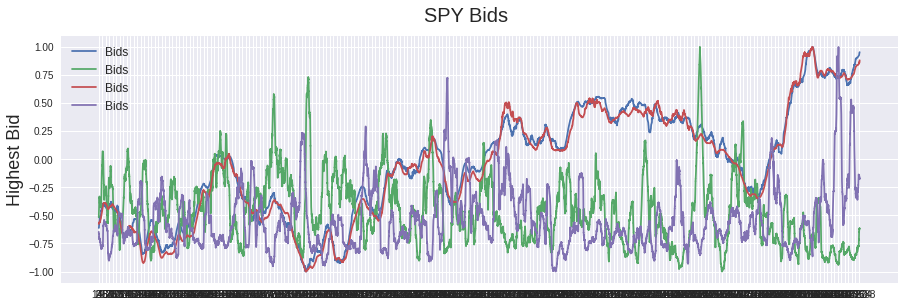

In [9]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df, label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

<h2>Model, Optimizer, and Criterion</h2>

In [10]:
import tkn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = df.shape[1]

# TODO: AFTER UNCERTAINTY IS IMPLEMENTED, UNCOMMENT
#OUTPUT_DIM = INPUT_DIM * 2
OUTPUT_DIM = INPUT_DIM

# HID_DIM = 256
# ENC_LAYERS = 2
# DEC_LAYERS = 2
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# MAX_IN = 128
# MAX_OUT = 128

HID_DIM = 32
ENC_LAYERS = 1
DEC_LAYERS = 1
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.05
DEC_DROPOUT = 0.05

MAX_IN = 512
MAX_OUT = 512

enc = tkn.Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device, max_length=MAX_IN)

dec = tkn.Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device, max_length=MAX_OUT)

cuda


In [27]:
#TODO: CHANGE PAD value
SRC_PAD = [-9 for _ in range(INPUT_DIM)]
TRG_PAD = [-9 for _ in range(OUTPUT_DIM)]

SRC_PAD_IDX = torch.FloatTensor(SRC_PAD).to(device)
TRG_PAD_IDX = torch.FloatTensor(OUTPUT_DIM).to(device)

In [12]:
model = tkn.TKN(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 62,916 trainable parameters


In [14]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

In [15]:
LEARNING_RATE = 0.005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

# TODO: create custom criterion
criterion = nn.MSELoss()

<h2>Batch Generation</h2>

In [16]:
from random import random

#TODO: generate variable length sequences
def gen_loader(data, batch_size, in_len, out_len, device, prop=.01):
    inps = []
    tgts = []
    
    for i in range(len(data) - in_len - out_len + 1):
        if (random() <= prop):
            inps.append(data[i:i+in_len])
            # TODO: add target uncertainty
            tgts.append(np.concatenate(([TRG_PAD], data[i+in_len-1:i+in_len+out_len-1]),axis=0))
        
    # TODO: set device to cpu because more RAM is available
    inps = torch.FloatTensor(inps).to(device)
    tgts = torch.FloatTensor(tgts).to(device)
    
    dataset = torch.utils.data.TensorDataset(inps, tgts)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    total = 0
    
    for i, data in enumerate(loader):        
        inp = data[0]
        tgt = data[1]
        
        optimizer.zero_grad()
        
        output = model(inp, tgt[:,:-1])
        
        loss = criterion(output, tgt[:,1:])
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        total = i
        
    return epoch_loss / total



def evaluate(model, loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    total = 0
    
    with torch.no_grad():
    
        for i, data in enumerate(loader):
            inp = data[0]
            tgt = data[1]
            
            output = model(inp, tgt[:,:-1])
        
            loss = criterion(output, tgt[:,1:])

            epoch_loss += loss.item()
            
            total = i
        
    return epoch_loss / total

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
TRAIN_RATIO = .8
BATCH_SIZE = 64

T_INDEX = math.ceil(TRAIN_RATIO * len(df))

tdf = df[:T_INDEX]
vdf = df[T_INDEX:]

train_iterator = gen_loader(tdf, BATCH_SIZE, MAX_IN, MAX_OUT, device)
valid_iterator = gen_loader(vdf, BATCH_SIZE, MAX_IN, MAX_OUT, device)

In [20]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    scheduler.step()
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tkn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.257 | Train PPL:   1.293
	 Val. Loss: 0.037 |  Val. PPL:   1.038
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.024 | Train PPL:   1.024
	 Val. Loss: 0.026 |  Val. PPL:   1.026
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.014 | Train PPL:   1.014
	 Val. Loss: 0.021 |  Val. PPL:   1.022
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.011 | Train PPL:   1.011
	 Val. Loss: 0.016 |  Val. PPL:   1.017
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.009 | Train PPL:   1.009
	 Val. Loss: 0.014 |  Val. PPL:   1.014
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.009 | Train PPL:   1.009
	 Val. Loss: 0.013 |  Val. PPL:   1.013
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.008 | Train PPL:   1.008
	 Val. Loss: 0.012 |  Val. PPL:   1.012
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.007 | Train PPL:   1.007
	 Val. Loss: 0.012 |  Val. PPL:   1.012
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.007 | Train PPL:   1.007
	 Val. Loss: 0.012 |  Val. PPL:   1.012
Epoch: 10 | Time: 0m 4s
	Train Loss: 0.007 | Train PPL:   1.007


Epoch: 80 | Time: 0m 3s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.015 |  Val. PPL:   1.015
Epoch: 81 | Time: 0m 3s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.015 |  Val. PPL:   1.015
Epoch: 82 | Time: 0m 3s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.016 |  Val. PPL:   1.016
Epoch: 83 | Time: 0m 3s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.015 |  Val. PPL:   1.015
Epoch: 84 | Time: 0m 3s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.016 |  Val. PPL:   1.016
Epoch: 85 | Time: 0m 3s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.016 |  Val. PPL:   1.016
Epoch: 86 | Time: 0m 3s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.014 |  Val. PPL:   1.015
Epoch: 87 | Time: 0m 3s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.014 |  Val. PPL:   1.015
Epoch: 88 | Time: 0m 4s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.017 |  Val. PPL:   1.017
Epoch: 89 | Time: 0m 3s
	Train Loss: 0.003 | Train PPL:   1.003


In [32]:
model.load_state_dict(torch.load('tkn-model.pt'))

# TODO: change valid to test iterator
test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.008 | Test PPL:   1.008 |


In [33]:
def predict_seq(src_tensor, model, device, max_len = MAX_OUT, start_vec=None):
    
    model.eval()
    
    #src_tensor = torch.reshape(src_tensor, (1,src_tensor.shape[0],-1))
    src_tensor = src_tensor.unsqueeze(0)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    if start_vec is not None:
        out_seq = start_vec.unsqueeze(0).unsqueeze(0)
    else:
        out_seq = TRG_PAD_IDX.unsqueeze(0).unsqueeze(0)
    
    for i in range(max_len):
        trg_mask = model.make_trg_mask(out_seq)
        
        with torch.no_grad():
            output = model.decoder(out_seq, enc_src, trg_mask, src_mask)
        pred = output[:,-1,:].unsqueeze(0)
        out_seq = torch.cat((out_seq, pred), 1)
    
    return out_seq

In [34]:
# TODO: display attention

In [35]:
ex_seq = df[-(MAX_IN+MAX_OUT):]
        
ex_inps = torch.FloatTensor(ex_seq[:MAX_IN]).to(device)
ex_tgts = torch.FloatTensor(ex_seq[MAX_IN:]).to(device)

In [36]:
pred = predict_seq(ex_inps, model, device)

pred = pred[0].cpu().numpy()
pred = pred[1:]

ex_tgts = ex_tgts.cpu().numpy()

print(f'predicted trg = {pred}')

predicted trg = [[ 0.74903643 -0.663292    0.84181726 -0.25586277]
 [ 0.74634546 -0.7198628   0.85287833 -0.33047095]
 [ 0.7587311  -0.71502376  0.8529109  -0.32694697]
 ...
 [ 0.77331716 -0.7642452   0.8382909  -0.27976224]
 [ 0.7736808  -0.7604456   0.84014046 -0.27359533]
 [ 0.76963806 -0.76405114  0.83455706 -0.2845531 ]]


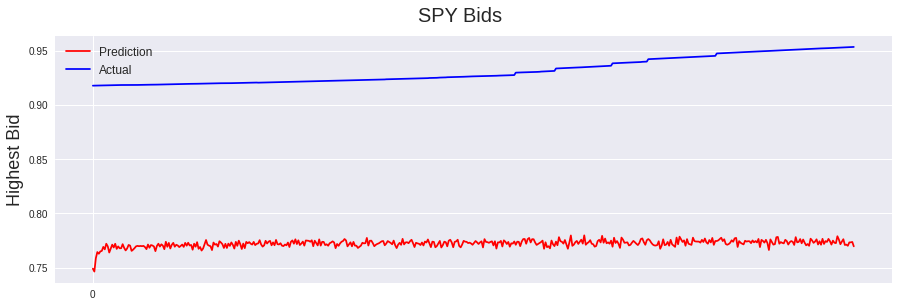

In [37]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)
ax1 = fig.add_subplot(211)
ax1.plot(pred[:,0], color='red', label='Prediction')
ax1.plot(ex_tgts[:,0], color='blue', label='Actual')
ax1.set_xticks(range(0, pred.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)